In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [ ]:
from IPython.display import display

import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, models, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

# Enable GPU device if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Pre-trained model techniques
The 'torchvision' and other PyTorch libraries provide many pre-trained models. These models allow us to solve problems with smaller datasets and less training time.

There are 3 ways to adapt pre-trained models for our purposes:
1. Load jsut model structure without pre-trained network parameters, replace the last layer to match n_classes in the target dataset, and train the entire network from scratch.
2. Fine-Tuning<br>
Load a pre-trained model, replace the last layer to match n_class, and train the entire network.
3. Transfer Learning<br>
Load a pre-trained model, replace the last layer to match n_class, and train only the parameters of the last layer while keeping the rest of the model frozen.

In [ ]:
DATA_ROOT = '/content/drive/MyDrive/datasets'
BATCH_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])
    ]
)

train_dataset = datasets.CIFAR10(
    root = DATA_ROOT, train = True,
    download = True, transform = transform)

test_dataset = datasets.CIFAR10(
    root = DATA_ROOT, train = False,
    download = True, transform = transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

classes = train_dataset.classes
n_class = len(classes)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train(model, criterion, optimizer, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.train()
    for inputs, labels in tqdm(data_loader, desc='Train', leave=False):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


@torch.no_grad()
def test(model, criterion, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.eval()
    for inputs, labels in tqdm(data_loader, desc='Test', leave=False):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


def train_and_test(num_epochs, model, criterion, optimizer, train_loader, test_loader, device):
    train_history = []
    test_history = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, criterion, optimizer, train_loader, device)
        test_loss, test_acc = test(model, criterion, test_loader, device)

        train_history.append([epoch, train_loss, train_acc])
        test_history.append([epoch, test_loss, test_acc])
        print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} test_loss: {test_loss:.5f}, test_acc: {test_acc:.5f}')

    return train_history, test_history

In [ ]:
from collections import OrderedDict

# Learning definition and the result variable.
KEYS = ['No Pre-trained', 'Fine Tuning', 'Transfer Learning']
NUM_EPOCHS = 10

results = OrderedDict({key: None for key in KEYS})

In [ ]:
# Pattern1: Just use vgg16 model without pre-trained parameters.
model = models.vgg16(pretrained=False)
n_fc_input = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(n_fc_input, n_class) # Replace the last layer.
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

results[KEYS[0]] = train_and_test(NUM_EPOCHS, model, criterion, optimizer, train_loader, test_loader, device)

In [ ]:
# Pattern2: Fine tuning for cifar10.
model = models.vgg16(pretrained=True)
n_fc_input = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(n_fc_input, n_class)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

results[KEYS[1]] = train_and_test(NUM_EPOCHS, model, criterion, optimizer, train_loader, test_loader, device)

In [ ]:
# Pattern3: Transfer learning for cifar10.
model = models.vgg16(pretrained=True)
n_fc_input = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(n_fc_input, n_class)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[-1].parameters(), lr = 0.0001)

results[KEYS[2]] = train_and_test(NUM_EPOCHS, model, criterion, optimizer, train_loader, test_loader, device)

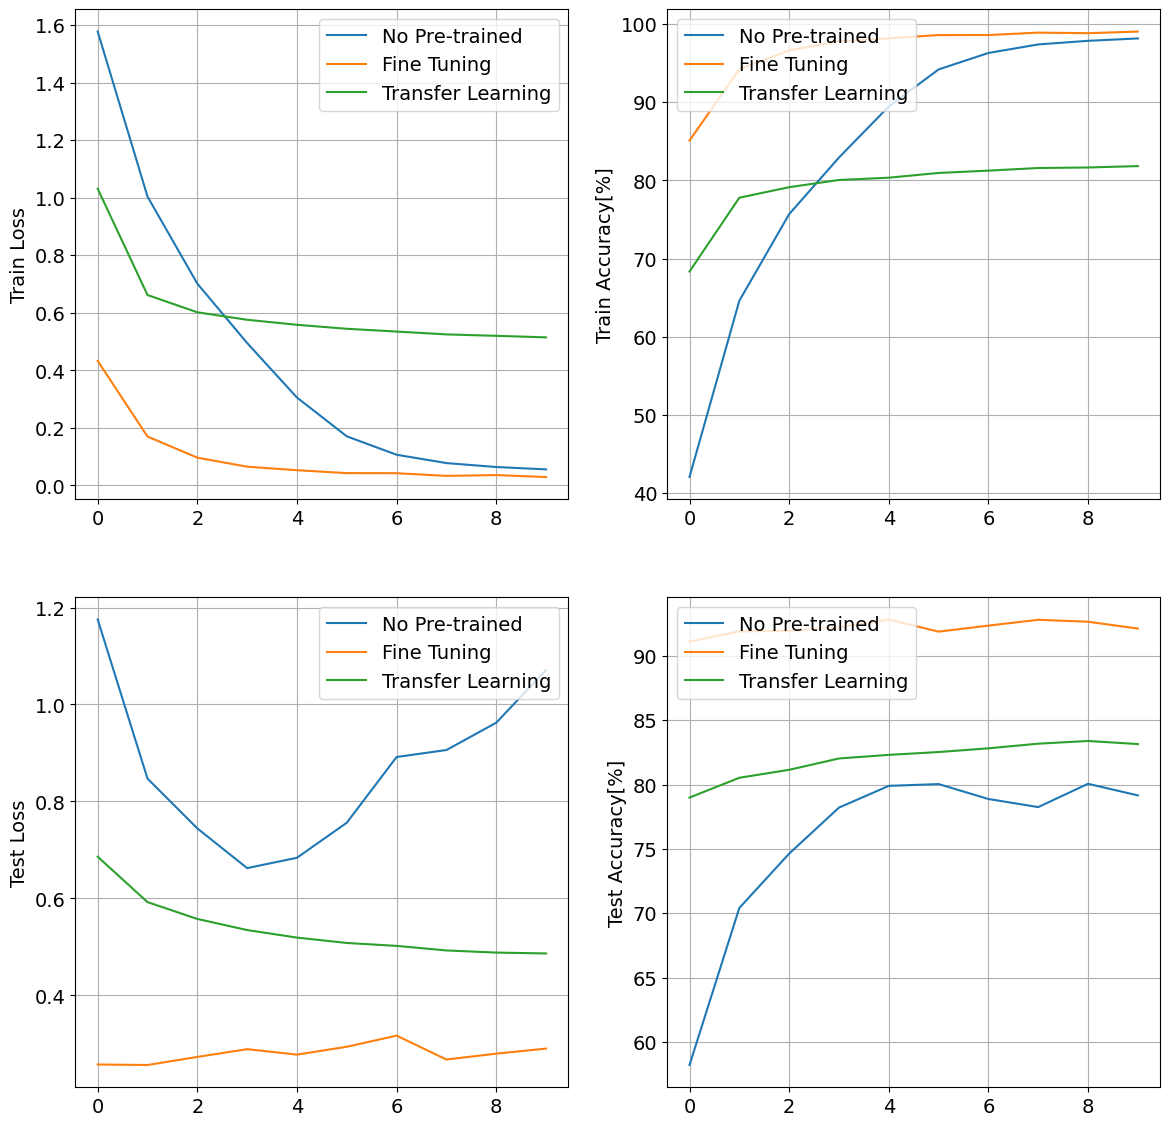

In [ ]:
COLORS = ['red', 'green', 'blue']

plt.figure(figsize=(14, 14))
for key, color in zip(KEYS, COLORS):
    train_history, test_history = results[key]
    train_history = np.array(train_history)
    test_history = np.array(test_history)

    ax = plt.subplot(2, 2, 1)
    ax.set_ylabel('Train Loss')
    ax.plot(train_history[:, 0], train_history[:, 1], label=key)
    ax.legend(loc='upper right')

    ax = plt.subplot(2, 2, 2)
    ax.set_ylabel('Train Accuracy[%]')
    ax.plot(train_history[:, 0], train_history[:, 2] * 100, label=key)
    ax.legend(loc='upper left')

    ax = plt.subplot(2, 2, 3)
    ax.set_ylabel('Test Loss')
    ax.plot(test_history[:, 0], test_history[:, 1], label=key)
    ax.legend(loc='upper right')

    ax = plt.subplot(2, 2, 4)
    ax.set_ylabel('Test Accuracy[%]')
    ax.plot(test_history[:, 0], test_history[:, 2] * 100, label=key)
    ax.legend(loc='upper left')

plt.show()

In [ ]:
# from google.colab import runtime
# runtime.unassign()